Import the necessary libraries and packages

In [21]:
import pandas as pd
from pomegranate import*
from block_learning.save_bn import save_model
from block_learning.read_bn import read_model
from block_learning.connect_BNs import connect_models
from block_learning.sampling import sample

import seaborn as sns



Load the necessary data.  
The data was collected from the social network VKontakte using an open API.  
The variables are the following: 
## Socio-demographic data 
`id` - id of a user  
`age`  
`gender`  
`city` - city code  
`education_status`  
`relation` - marital status  
`relatives` - number of relatives  

## Information about interests  
`love_relation` - the degree of interest in this topic [0,100]  
`sport_fitness` - the degree of interest in this topic [0,100]  
`job_money` - the degree of interest in this topic [0,100]  
`history_politics` - the degree of interest in this topic [0,100]  
`news` - the degree of interest in this topic [0,100]  

## Social network activity metrics
`friends` - number of friends  
`followers` - number of followers  
`avg_likes` - number of likes per post  
`posts` - total number of posts  
`avg_views` - number of views per post  
`repost_ratio` - share of reposts on user page  





In [22]:
vk_data = pd.read_csv('data/modules_vk_discrete.csv')
train_data = pd.read_csv('data/train_vk_data.csv')
test_data = pd.read_csv('data/test_vk_data.csv')


The main idea is to build a modular structure of Bayesian networks, where each network represents some level of a person’s personal description.   
An example of such a structure is shown in the picture.

![title](img/modules_scheme.png)

Divide the data into the necessary modules

In [24]:
module1 = train_data[['age','sex','city','education_status','relation','relatives']]
module2 = train_data[['love_relation','sport_fitness','job_money','history_politics','news']]
module3 = train_data[['friends','followers','avg_likes','posts','avg_views','repost_ratio']]

Let's start learning the structure and parameters of the Bayesian network on the first module.  
The model as a result will be saved as a json file in the folder "modules"

In [25]:
save_model(data=module1.values,restrict=[2,3,4,5,6],name='module1')

Now read the saved model

In [26]:
bn1 = read_model('module1')

You can see the structure of the model. Each tuple is a collection of node parents.  
As we see, in this structure there were two initializing nodes - age and gender, since they do not have parents.

In [27]:
bn1.structure

((), (), (1, 4), (0, 5), (0, 1), (0, 1), (1, 3, 5))

Now connect the already trained model with the new network structure, which will be trained on the data of the second module.

In [28]:
connect_models(bn1=bn1,data=module2.values,name='module_1_2',restrict=[1,2,3,4,5,6])

In [29]:
bn12 = read_model('module_1_2')

We repeat the same connection procedure, now we add the third to the connected two modules.

In [30]:
connect_models(bn1=bn12,data=module3.values,name='module_1_2_3',restrict=[1,2,3,4,5,6,7])

In [31]:
bn123 = read_model('module_1_2_3')

The overall block network structure will look something like this.  
![title](img/BN-1.png)

Now you can start sampling the data. Data can be sampled at each level, for example, at the level of the first module.

In [33]:
module1_sample = sample(bn1,3876)

You can look at the marginal distribution of test and sampled data.  
Blue is real data.  

Orange is synthetic data.

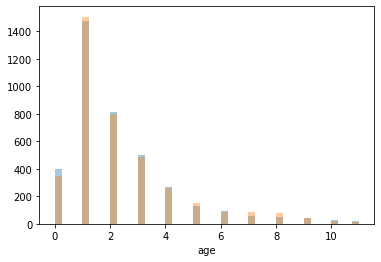

In [35]:
sns.distplot(test_data['age'],kde=False)
sns.distplot(module1_sample[0],kde=False)

In [36]:
module2_sample = sample(bn12,3876)

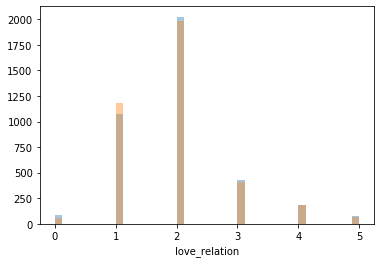

In [39]:
sns.distplot(test_data['love_relation'],kde=False)
sns.distplot(module2_sample[1],kde=False)

In [40]:
module3_sample = sample(bn123,3876)

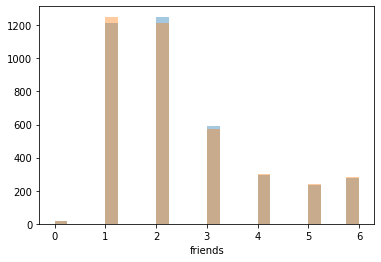

In [41]:
sns.distplot(test_data['friends'],kde=False)
sns.distplot(module3_sample[1],kde=False)